# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.today()
today

datetime.datetime(2024, 11, 19, 14, 57, 15, 972112)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# UNCOMMENT if not running as a GitHub action
# with open('../data/hopsworks-api-key.txt', 'r') as file:
#     os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159324
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='6.357394E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read(read_options={"use_hive": True})
batch_data

2024-11-19 14:57:25,375 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (1.49s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-20,4.45,0.0,18.472595,303.070680,brno
1,2024-11-21,4.20,0.0,17.377226,283.172550,brno
2,2024-11-22,3.15,0.0,20.683560,301.476780,brno
3,2024-11-23,1.65,0.0,17.906157,300.173430,brno
4,2024-11-24,2.15,0.0,10.514218,128.047090,brno
5,2024-11-25,4.15,0.0,12.261157,139.763720,brno
6,2024-11-26,5.25,0.0,4.334974,221.633450,brno
7,2024-11-27,6.95,0.0,8.435069,320.194500,brno
8,2024-11-28,4.90,0.0,11.720751,47.489597,brno


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-20,4.45,0.0,18.472595,303.070680,brno,78.350136
1,2024-11-21,4.20,0.0,17.377226,283.172550,brno,75.357872
2,2024-11-22,3.15,0.0,20.683560,301.476780,brno,89.219162
3,2024-11-23,1.65,0.0,17.906157,300.173430,brno,104.012047
4,2024-11-24,2.15,0.0,10.514218,128.047090,brno,103.588814
5,2024-11-25,4.15,0.0,12.261157,139.763720,brno,96.372009
6,2024-11-26,5.25,0.0,4.334974,221.633450,brno,114.345055
7,2024-11-27,6.95,0.0,8.435069,320.194500,brno,99.427773
8,2024-11-28,4.90,0.0,11.720751,47.489597,brno,100.250610


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[ns]
 1   temperature_2m_mean          9 non-null      float64       
 2   precipitation_sum            9 non-null      float64       
 3   wind_speed_10m_max           9 non-null      float64       
 4   wind_direction_10m_dominant  9 non-null      float64       
 5   city                         9 non-null      object        
 6   predicted_pm25               9 non-null      float32       
dtypes: datetime64[ns](1), float32(1), float64(4), object(1)
memory usage: 600.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country
0,2024-11-20,4.45,0.0,18.472595,303.070680,brno,78.350136,svatoplukova,czechia
1,2024-11-21,4.20,0.0,17.377226,283.172550,brno,75.357872,svatoplukova,czechia
2,2024-11-22,3.15,0.0,20.683560,301.476780,brno,89.219162,svatoplukova,czechia
3,2024-11-23,1.65,0.0,17.906157,300.173430,brno,104.012047,svatoplukova,czechia
4,2024-11-24,2.15,0.0,10.514218,128.047090,brno,103.588814,svatoplukova,czechia
5,2024-11-25,4.15,0.0,12.261157,139.763720,brno,96.372009,svatoplukova,czechia
6,2024-11-26,5.25,0.0,4.334974,221.633450,brno,114.345055,svatoplukova,czechia
7,2024-11-27,6.95,0.0,8.435069,320.194500,brno,99.427773,svatoplukova,czechia
8,2024-11-28,4.90,0.0,11.720751,47.489597,brno,100.250610,svatoplukova,czechia


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[ns]
 1   temperature_2m_mean          9 non-null      float64       
 2   precipitation_sum            9 non-null      float64       
 3   wind_speed_10m_max           9 non-null      float64       
 4   wind_direction_10m_dominant  9 non-null      float64       
 5   city                         9 non-null      object        
 6   predicted_pm25               9 non-null      float32       
 7   street                       9 non-null      object        
 8   country                      9 non-null      object        
dtypes: datetime64[ns](1), float32(1), float64(4), object(3)
memory usage: 744.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-19 14:57:28,342 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



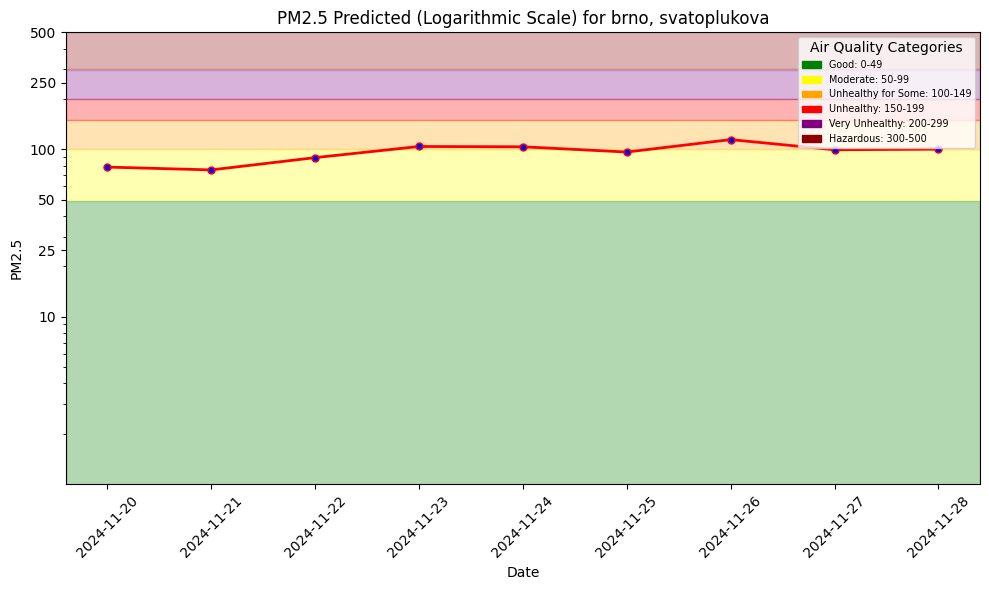

In [12]:
# Prediction path save image
import os

# Ensure the directory exists
output_dir = "../docs/air-quality/assets/img/"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

file_path = os.path.join(output_dir, "pm25_forecast.png")
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date'],
    event_time="date"
)

In [14]:
# stupid error
batch_data["precipitation_sum"] = batch_data["precipitation_sum"].astype("float32")
batch_data["temperature_2m_mean"] = batch_data["temperature_2m_mean"].astype("float32")
batch_data["wind_speed_10m_max"] = batch_data["wind_speed_10m_max"].astype("float32")
batch_data["wind_direction_10m_dominant"] = batch_data["wind_direction_10m_dominant"].astype("float32")

In [15]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159324/jobs/named/aq_predictions_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0xffff282e4710>, None)

In [16]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country
0,2024-11-20,4.45,0.0,18.472595,303.070679,brno,78.350136,svatoplukova,czechia
1,2024-11-21,4.20,0.0,17.377226,283.172546,brno,75.357872,svatoplukova,czechia
2,2024-11-22,3.15,0.0,20.683559,301.476776,brno,89.219162,svatoplukova,czechia
3,2024-11-23,1.65,0.0,17.906157,300.173431,brno,104.012047,svatoplukova,czechia
4,2024-11-24,2.15,0.0,10.514218,128.047089,brno,103.588814,svatoplukova,czechia
5,2024-11-25,4.15,0.0,12.261157,139.763718,brno,96.372009,svatoplukova,czechia
6,2024-11-26,5.25,0.0,4.334974,221.633453,brno,114.345055,svatoplukova,czechia
7,2024-11-27,6.95,0.0,8.435069,320.194489,brno,99.427773,svatoplukova,czechia
8,2024-11-28,4.90,0.0,11.720751,47.489597,brno,100.250610,svatoplukova,czechia


In [17]:
seven_days_ago = today - datetime.timedelta(days=14)

monitoring_df = monitor_fg.filter(monitor_fg.date < today).filter(monitor_fg.date >= seven_days_ago).read(read_options={"use_hive": True})
monitoring_df = monitoring_df.sort_values(by=['date'], ascending=False)
monitoring_df

2024-11-19 14:58:52,769 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (1.32s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country
12,2024-11-19,6.350000,0.1,18.289274,169.796080,brno,67.204480,svatoplukova,czechia
10,2024-11-18,9.250000,0.0,27.009598,268.472500,brno,44.171240,svatoplukova,czechia
7,2024-11-17,7.000000,0.0,11.384198,235.304780,brno,81.664430,svatoplukova,czechia
3,2024-11-16,4.125999,0.0,11.633348,155.768230,brno,99.746740,svatoplukova,czechia
9,2024-11-15,6.111416,0.0,13.954354,308.469060,brno,79.887680,svatoplukova,czechia
2,2024-11-14,4.142666,0.2,12.886039,276.385470,brno,59.770195,svatoplukova,czechia
8,2024-11-13,2.382250,0.0,6.269067,312.941620,brno,126.595770,svatoplukova,czechia
13,2024-11-12,2.257250,0.0,8.604301,38.620228,brno,90.624626,svatoplukova,czechia
11,2024-11-11,1.159333,0.0,5.157558,184.635450,brno,125.060890,svatoplukova,czechia
1,2024-11-10,2.055166,0.0,8.738811,29.599749,brno,84.156395,svatoplukova,czechia


In [18]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.select(["date", "pm25"]).read(read_options={"use_hive": True})
air_quality_df

2024-11-19 14:58:56,369 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (2.03s) 


,date,pm25
0,2023-03-09,36.0
1,2024-07-01,34.0
2,2020-07-30,34.0
3,2022-02-11,55.0
4,2021-09-24,30.0
...,...,...
3725,2024-11-17,72.0
3726,2024-11-18,45.0
3727,2024-11-10,102.0
3728,2024-11-08,128.0


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
12,2024-11-06,90.128900,88.0
11,2024-11-07,103.131230,99.0
10,2024-11-08,95.859190,128.0
9,2024-11-09,104.886410,119.0
8,2024-11-10,84.156395,102.0
7,2024-11-11,125.060890,80.0
6,2024-11-12,90.624626,68.0
5,2024-11-13,126.595770,51.0
4,2024-11-14,59.770195,55.0
3,2024-11-15,79.887680,50.0


In [20]:
preds_df.sort_values(by="date").tail(10)

,date,predicted_pm25
1,2024-11-10,84.156395
11,2024-11-11,125.060890
13,2024-11-12,90.624626
8,2024-11-13,126.595770
2,2024-11-14,59.770195
9,2024-11-15,79.887680
3,2024-11-16,99.746740
7,2024-11-17,81.664430
10,2024-11-18,44.171240
12,2024-11-19,67.204480


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

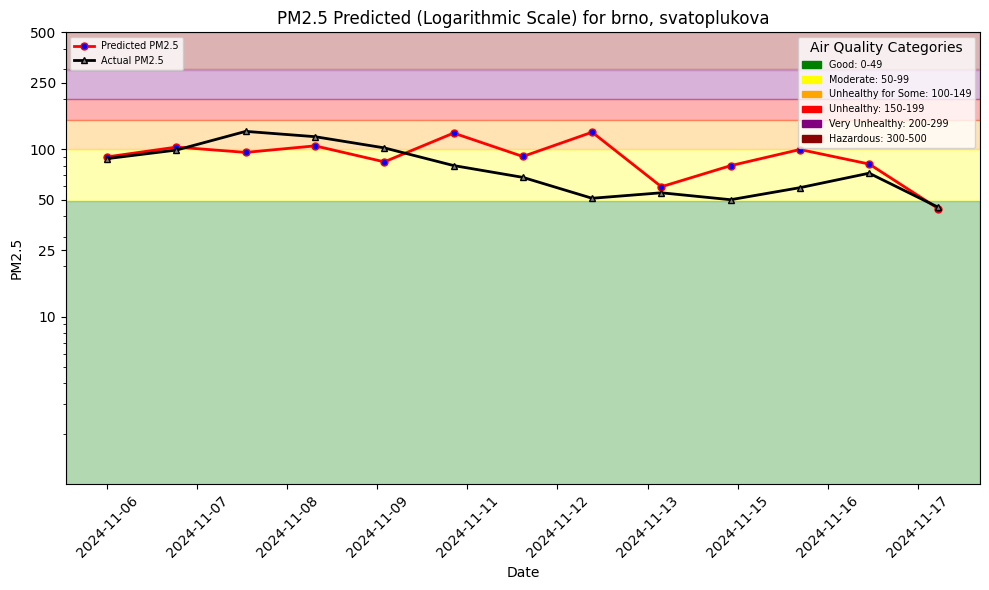

In [21]:
file_path = "../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---